<h1>🚘 TireNET. | Tire Condition Monitoring System</h1>
<p>This project focuses on tire condition classification using deep learning. The system can classify tire conditions into two categories: Good (safe to use) and Defective (requires replacement) using the MobileNetV2 with CBAM (Convolutional Block Attention Module) architecture.</p>

<h2>Data Understanding</h2>
<hr>

### Import Library & Setup

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchvision.transforms.functional as TF

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tqdm import tqdm
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Using device: cuda
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU
GPU Memory: 4.00 GB


In [3]:
os.makedirs('config', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('scripts', exist_ok=True)
os.makedirs('src', exist_ok=True)
os.makedirs('utils', exist_ok=True)
os.makedirs('.streamlit', exist_ok=True)

print("\n✓ Folder structure created successfully")


✓ Folder structure created successfully


In [4]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Data Exploration

In [5]:
DATA_PATH = Path('data')
CLASSES = ['good', 'defective']

def collect_image_paths(data_path):
    data = []
    for class_name in CLASSES:
        class_path = data_path / class_name
        if class_path.exists():
            for img_path in class_path.glob('*.*'):
                if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
                    data.append({
                        'path': str(img_path),
                        'label': class_name,
                        'label_idx': CLASSES.index(class_name)
                    })
    return pd.DataFrame(data)

In [7]:
df = collect_image_paths(DATA_PATH)
print(f"\nTotal images: {len(df)}")
print(f"\nClass Distribution:")
print(df['label'].value_counts())


Total images: 1856

Class Distribution:
label
defective    1028
good          828
Name: count, dtype: int64


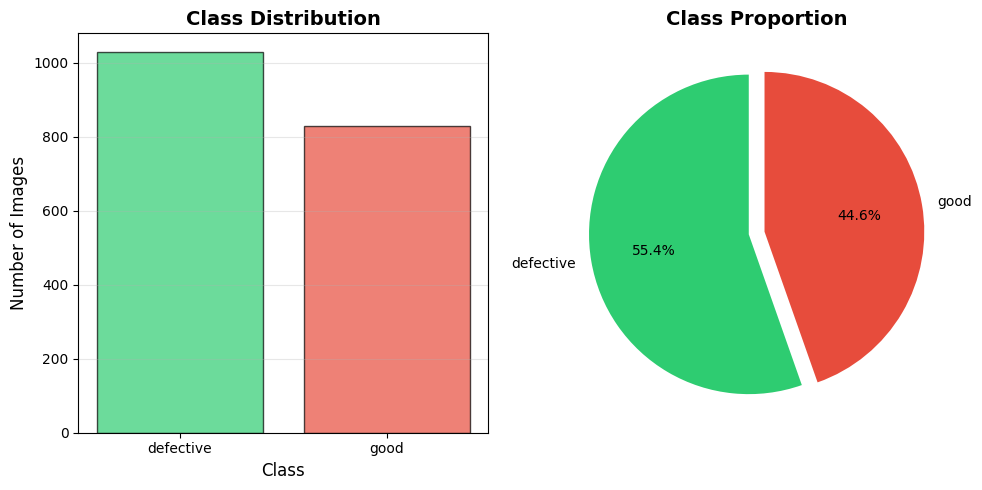

In [8]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
class_counts = df['label'].value_counts()
colors = ['#2ecc71', '#e74c3c']
plt.bar(class_counts.index, class_counts.values, color=colors, alpha=0.7, edgecolor='black')
plt.title('Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90, explode=(0.05, 0.05))
plt.title('Class Proportion', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('results/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

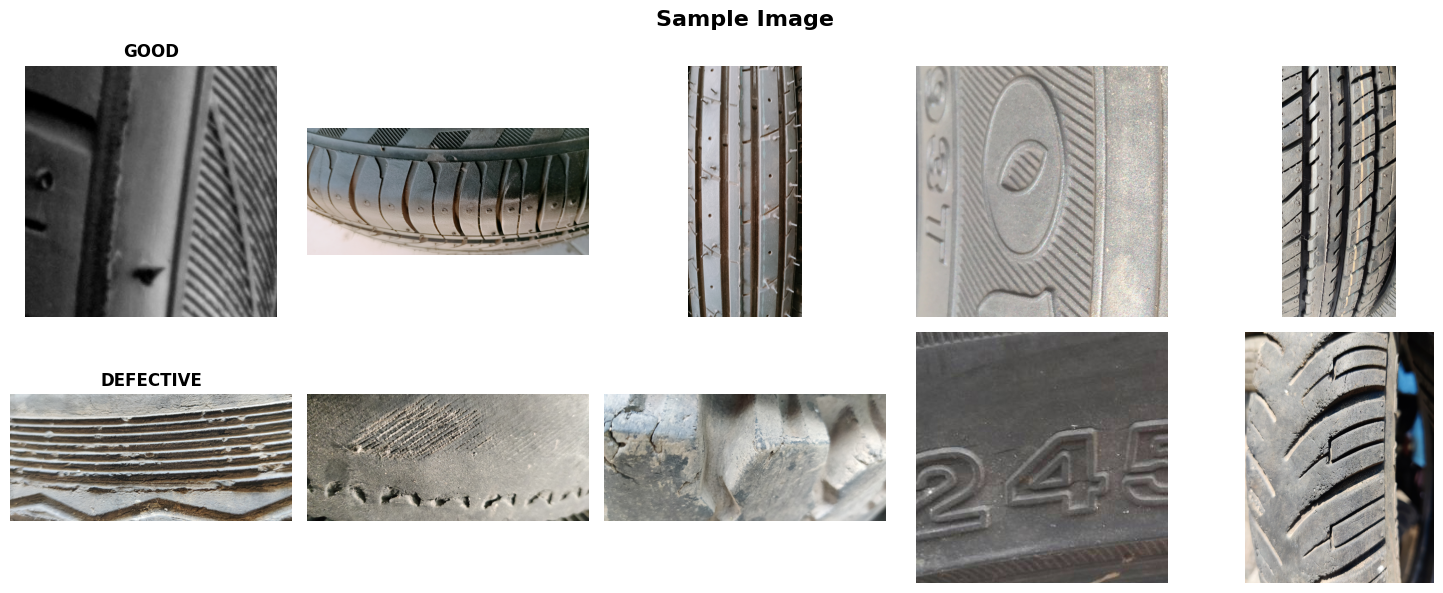

In [9]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Image', fontsize=16, fontweight='bold')

for idx, class_name in enumerate(CLASSES):
    class_samples = df[df['label'] == class_name].sample(5, random_state=SEED)
    for i, (_, row) in enumerate(class_samples.iterrows()):
        img = Image.open(row['path'])
        axes[idx, i].imshow(img)
        axes[idx, i].axis('off')
        if i == 0:
            axes[idx, i].set_title(f'{class_name.upper()}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('results/sample_images.png', dpi=300, bbox_inches='tight')
plt.show()

<h2>Data Preprocessing</h2>
<hr>

In [10]:
class TireDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'path']
        label = self.dataframe.loc[idx, 'label_idx']
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df['label'], random_state=SEED
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['label'], random_state=SEED
)

print(f"\nData Split:")
print(f"Train: {len(train_df)} samples")
print(f"Validation: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")

print(f"\nTrain distribution:\n{train_df['label'].value_counts()}")
print(f"\nValidation distribution:\n{val_df['label'].value_counts()}")
print(f"\nTest distribution:\n{test_df['label'].value_counts()}")



Data Split:
Train: 1299 samples
Validation: 278 samples
Test: 279 samples

Train distribution:
label
defective    719
good         580
Name: count, dtype: int64

Validation distribution:
label
defective    154
good         124
Name: count, dtype: int64

Test distribution:
label
defective    155
good         124
Name: count, dtype: int64


<h2>Modeling</h2>
<hr>

In [21]:
CONFIG = {
    'batch_size': 32,
    'num_epochs': 30,
    'learning_rate': 0.001,
    'weight_decay': 1e-4,
    'patience': 10,  # untuk early stopping
    'num_classes': len(CLASSES),
    'image_size': 224,
    'model_name': 'MobileNetV2_CBAM',
    'optimizer': 'Adam',
    'scheduler': 'ReduceLROnPlateau',
    'device': str(device)
}

print("\nHyperparameter Configuration:")
for key, value in CONFIG.items():
    print(f"{key}: {value}")

# Save config
os.makedirs('config', exist_ok=True)
with open('config/train_config.json', 'w') as f:
    json.dump(CONFIG, f, indent=4)


Hyperparameter Configuration:
batch_size: 32
num_epochs: 30
learning_rate: 0.001
weight_decay: 0.0001
patience: 10
num_classes: 2
image_size: 224
model_name: MobileNetV2_CBAM
optimizer: Adam
scheduler: ReduceLROnPlateau
device: cuda


In [22]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return self.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention(kernel_size)
    
    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

class MobileNetV2_CBAM(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(MobileNetV2_CBAM, self).__init__()
        
        # Load pretrained MobileNetV2
        mobilenet = models.mobilenet_v2(pretrained=pretrained)
        self.features = mobilenet.features
        
        # Add CBAM after last convolutional layer
        # MobileNetV2 last conv layer has 1280 channels
        self.cbam = CBAM(in_channels=1280, reduction=16)
        
        # Classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.cbam(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = MobileNetV2_CBAM(num_classes=CONFIG['num_classes'], pretrained=True)
model = model.to(device)

In [23]:
print("\nModel Architecture:")
model


Model Architecture:


MobileNetV2_CBAM(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96,

In [24]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")


Total Parameters: 2,431,332
Trainable Parameters: 2,431,332


In [25]:
# Create datasets and dataloaders
train_dataset = TireDataset(train_df, transform=train_transform)
val_dataset = TireDataset(val_df, transform=val_test_transform)
test_dataset = TireDataset(test_df, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], 
                          shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], 
                        shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], 
                         shuffle=False, num_workers=0, pin_memory=True)

# Loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], 
                       weight_decay=CONFIG['weight_decay'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                  factor=0.5, patience=5)

# Training function
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': running_loss/len(dataloader), 
                         'acc': 100.*correct/total})
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({'loss': running_loss/len(dataloader), 
                             'acc': 100.*correct/total})
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Training loop
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
patience_counter = 0

print("\n" + "="*70)
print("STARTING TRAINING")
print("="*70)

for epoch in range(CONFIG['num_epochs']):
    print(f"\nEpoch [{epoch+1}/{CONFIG['num_epochs']}]")
    print("-" * 70)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"\nTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'config': CONFIG
        }, 'models/best_model.pth')
        print(f"✓ Best model saved! (Val Acc: {val_acc:.2f}%)")
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= CONFIG['patience']:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print("\n" + "="*70)
print("TRAINING COMPLETED")
print("="*70)

# Save training history
with open('results/training_history.json', 'w') as f:
    json.dump(history, f, indent=4)


STARTING TRAINING

Epoch [1/30]
----------------------------------------------------------------------


Validation: 100%|██████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.11s/it, loss=0.221, acc=92.4]



Train Loss: 0.3756, Train Acc: 83.06%
Val Loss: 0.2207, Val Acc: 92.45%
✓ Best model saved! (Val Acc: 92.45%)

Epoch [2/30]
----------------------------------------------------------------------


Validation: 100%|██████████████████████████████████████████████████| 9/9 [00:19<00:00,  2.11s/it, loss=0.191, acc=92.8]



Train Loss: 0.2646, Train Acc: 88.99%
Val Loss: 0.1910, Val Acc: 92.81%
✓ Best model saved! (Val Acc: 92.81%)

Epoch [3/30]
----------------------------------------------------------------------


Validation: 100%|██████████████████████████████████████████████████| 9/9 [00:19<00:00,  2.16s/it, loss=0.181, acc=92.1]



Train Loss: 0.2341, Train Acc: 90.69%
Val Loss: 0.1810, Val Acc: 92.09%

Epoch [4/30]
----------------------------------------------------------------------


Validation: 100%|██████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.01s/it, loss=0.175, acc=93.2]



Train Loss: 0.1964, Train Acc: 92.46%
Val Loss: 0.1749, Val Acc: 93.17%
✓ Best model saved! (Val Acc: 93.17%)

Epoch [5/30]
----------------------------------------------------------------------


Validation: 100%|██████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.06s/it, loss=0.115, acc=95.3]



Train Loss: 0.2063, Train Acc: 92.15%
Val Loss: 0.1146, Val Acc: 95.32%
✓ Best model saved! (Val Acc: 95.32%)

Epoch [6/30]
----------------------------------------------------------------------


Validation: 100%|████████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.10s/it, loss=0.115, acc=95]



Train Loss: 0.2103, Train Acc: 91.38%
Val Loss: 0.1146, Val Acc: 94.96%

Epoch [7/30]
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.04s/it, loss=0.15, acc=92.4]



Train Loss: 0.1475, Train Acc: 94.23%
Val Loss: 0.1504, Val Acc: 92.45%

Epoch [8/30]
----------------------------------------------------------------------


Validation: 100%|██████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.04s/it, loss=0.141, acc=93.5]



Train Loss: 0.1309, Train Acc: 95.15%
Val Loss: 0.1415, Val Acc: 93.53%

Epoch [9/30]
----------------------------------------------------------------------


Validation: 100%|██████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.10s/it, loss=0.294, acc=86.7]



Train Loss: 0.1534, Train Acc: 93.69%
Val Loss: 0.2939, Val Acc: 86.69%

Epoch [10/30]
----------------------------------------------------------------------


Validation: 100%|██████████████████████████████████████████████████| 9/9 [00:19<00:00,  2.15s/it, loss=0.132, acc=94.6]



Train Loss: 0.1399, Train Acc: 94.92%
Val Loss: 0.1315, Val Acc: 94.60%

Epoch [11/30]
----------------------------------------------------------------------


Validation: 100%|█████████████████████████████████████████████████| 9/9 [00:19<00:00,  2.12s/it, loss=0.0988, acc=95.3]



Train Loss: 0.1539, Train Acc: 93.92%
Val Loss: 0.0988, Val Acc: 95.32%

Epoch [12/30]
----------------------------------------------------------------------


Validation: 100%|██████████████████████████████████████████████████| 9/9 [00:19<00:00,  2.12s/it, loss=0.223, acc=90.6]



Train Loss: 0.1203, Train Acc: 95.30%
Val Loss: 0.2229, Val Acc: 90.65%

Epoch [13/30]
----------------------------------------------------------------------


Validation: 100%|██████████████████████████████████████████████████| 9/9 [00:20<00:00,  2.23s/it, loss=0.105, acc=95.7]



Train Loss: 0.1359, Train Acc: 95.00%
Val Loss: 0.1055, Val Acc: 95.68%
✓ Best model saved! (Val Acc: 95.68%)

Epoch [14/30]
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.11s/it, loss=0.24, acc=92.4]



Train Loss: 0.1062, Train Acc: 95.54%
Val Loss: 0.2400, Val Acc: 92.45%

Epoch [15/30]
----------------------------------------------------------------------


Validation: 100%|████████████████████████████████████████████████████| 9/9 [00:20<00:00,  2.24s/it, loss=0.119, acc=96]



Train Loss: 0.1325, Train Acc: 95.07%
Val Loss: 0.1194, Val Acc: 96.04%
✓ Best model saved! (Val Acc: 96.04%)

Epoch [16/30]
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████████████| 9/9 [00:19<00:00,  2.12s/it, loss=0.15, acc=94.6]



Train Loss: 0.1059, Train Acc: 95.61%
Val Loss: 0.1502, Val Acc: 94.60%

Epoch [17/30]
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.11s/it, loss=0.15, acc=95.3]



Train Loss: 0.1127, Train Acc: 95.38%
Val Loss: 0.1502, Val Acc: 95.32%

Epoch [18/30]
----------------------------------------------------------------------


Validation: 100%|██████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.06s/it, loss=0.104, acc=96.4]



Train Loss: 0.0788, Train Acc: 97.61%
Val Loss: 0.1044, Val Acc: 96.40%
✓ Best model saved! (Val Acc: 96.40%)

Epoch [19/30]
----------------------------------------------------------------------


Validation: 100%|██████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.09s/it, loss=0.146, acc=94.2]



Train Loss: 0.0566, Train Acc: 97.92%
Val Loss: 0.1457, Val Acc: 94.24%

Epoch [20/30]
----------------------------------------------------------------------


Validation: 100%|██████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.09s/it, loss=0.123, acc=96.4]



Train Loss: 0.0474, Train Acc: 98.00%
Val Loss: 0.1227, Val Acc: 96.40%

Epoch [21/30]
----------------------------------------------------------------------


Validation: 100%|██████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.06s/it, loss=0.116, acc=96.4]



Train Loss: 0.0458, Train Acc: 98.85%
Val Loss: 0.1156, Val Acc: 96.40%

Epoch [22/30]
----------------------------------------------------------------------


Validation: 100%|████████████████████████████████████████████████████| 9/9 [00:20<00:00,  2.24s/it, loss=0.151, acc=95]



Train Loss: 0.0578, Train Acc: 97.61%
Val Loss: 0.1509, Val Acc: 94.96%

Epoch [23/30]
----------------------------------------------------------------------


Validation: 100%|██████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.07s/it, loss=0.143, acc=95.7]



Train Loss: 0.0579, Train Acc: 97.77%
Val Loss: 0.1434, Val Acc: 95.68%

Epoch [24/30]
----------------------------------------------------------------------


Validation: 100%|██████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.10s/it, loss=0.105, acc=96.4]



Train Loss: 0.0390, Train Acc: 98.92%
Val Loss: 0.1048, Val Acc: 96.40%

Epoch [25/30]
----------------------------------------------------------------------


Validation: 100%|██████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.07s/it, loss=0.093, acc=96.8]



Train Loss: 0.0391, Train Acc: 98.31%
Val Loss: 0.0930, Val Acc: 96.76%
✓ Best model saved! (Val Acc: 96.76%)

Epoch [26/30]
----------------------------------------------------------------------


Validation: 100%|█████████████████████████████████████████████████| 9/9 [00:19<00:00,  2.13s/it, loss=0.0977, acc=96.4]



Train Loss: 0.0403, Train Acc: 98.38%
Val Loss: 0.0977, Val Acc: 96.40%

Epoch [27/30]
----------------------------------------------------------------------


Validation: 100%|█████████████████████████████████████████████████| 9/9 [00:19<00:00,  2.12s/it, loss=0.0845, acc=97.1]



Train Loss: 0.0547, Train Acc: 98.08%
Val Loss: 0.0845, Val Acc: 97.12%
✓ Best model saved! (Val Acc: 97.12%)

Epoch [28/30]
----------------------------------------------------------------------


Validation: 100%|█████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.08s/it, loss=0.0803, acc=96.4]



Train Loss: 0.0229, Train Acc: 99.31%
Val Loss: 0.0803, Val Acc: 96.40%

Epoch [29/30]
----------------------------------------------------------------------


Validation: 100%|█████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.09s/it, loss=0.0985, acc=97.1]



Train Loss: 0.0179, Train Acc: 99.31%
Val Loss: 0.0985, Val Acc: 97.12%

Epoch [30/30]
----------------------------------------------------------------------


Validation: 100%|██████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.05s/it, loss=0.135, acc=96.4]


Train Loss: 0.0151, Train Acc: 99.46%
Val Loss: 0.1350, Val Acc: 96.40%

TRAINING COMPLETED


<h2>Evaluation</h2>
<hr>


Best model loaded from epoch 27
Best validation accuracy: 97.12%


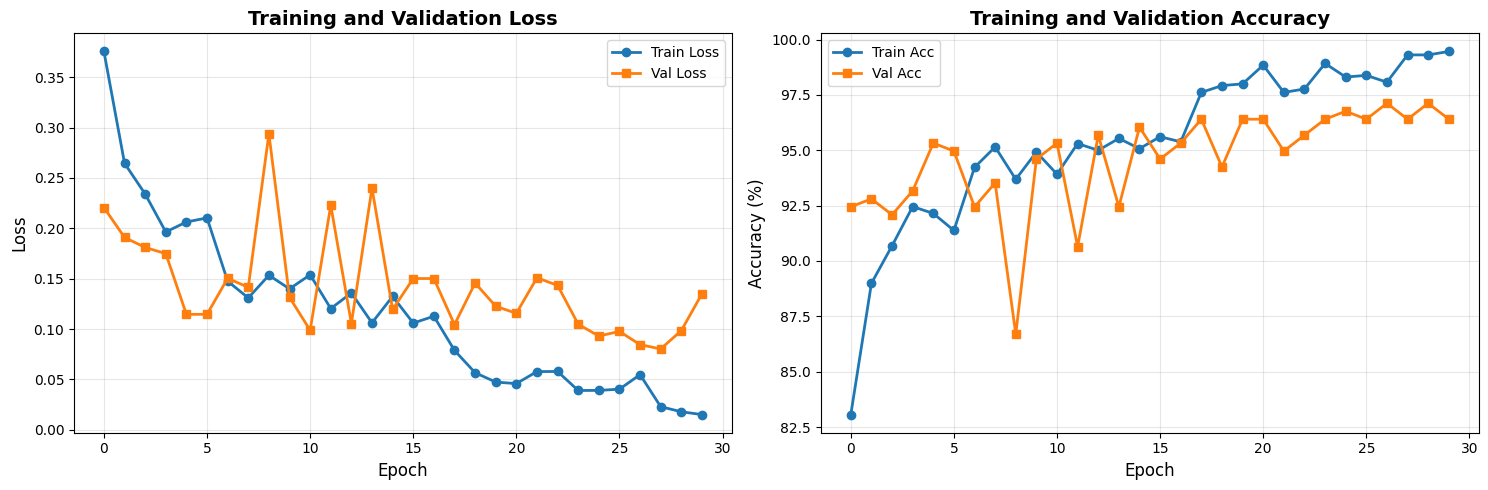

In [26]:
checkpoint = torch.load('models/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"\nBest model loaded from epoch {checkpoint['epoch']+1}")
print(f"Best validation accuracy: {checkpoint['val_acc']:.2f}%")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_acc'], label='Train Acc', marker='o', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Acc', marker='s', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Testing'):
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)

In [27]:
test_preds, test_labels = evaluate_model(model, test_loader, device)

Testing: 100%|███████████████████████████████████████████████████████████████████████████| 9/9 [00:20<00:00,  2.31s/it]


In [28]:
test_acc = accuracy_score(test_labels, test_preds)
print(f"\n{'='*70}")
print(f"TEST SET RESULTS")
print(f"{'='*70}")
print(f"\nTest Accuracy: {test_acc*100:.2f}%\n")
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=CLASSES, digits=4))


TEST SET RESULTS

Test Accuracy: 97.85%

Classification Report:
              precision    recall  f1-score   support

        good     0.9683    0.9839    0.9760       124
   defective     0.9869    0.9742    0.9805       155

    accuracy                         0.9785       279
   macro avg     0.9776    0.9790    0.9783       279
weighted avg     0.9786    0.9785    0.9785       279



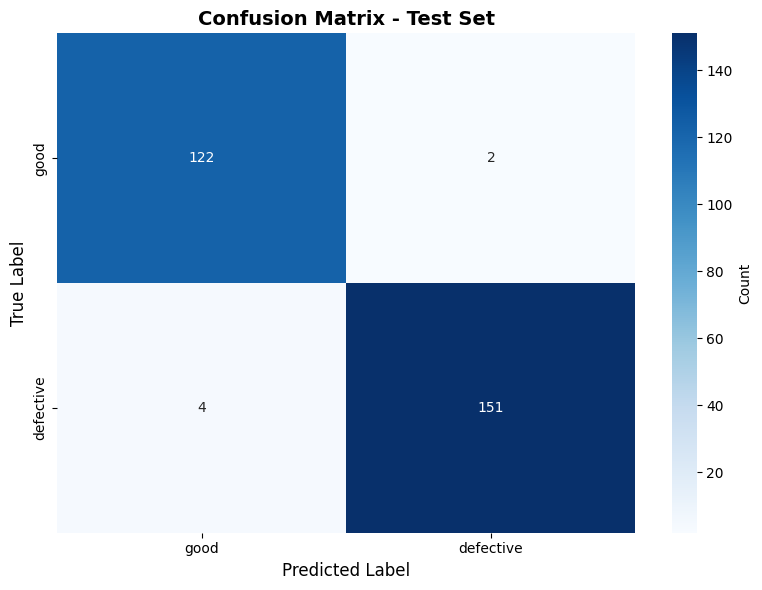


✓ All results saved to 'results/' directory
✓ Best model saved to 'models/best_model.pth'
✓ Configuration saved to 'config/train_config.json'


In [29]:
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASSES, yticklabels=CLASSES,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('results/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

results = {
    'test_accuracy': float(test_acc),
    'confusion_matrix': cm.tolist(),
    'classification_report': classification_report(test_labels, test_preds, 
                                                   target_names=CLASSES, 
                                                   output_dict=True),
    'best_val_accuracy': float(checkpoint['val_acc']),
    'training_epochs': len(history['train_loss'])
}

with open('results/test_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print(f"\n✓ All results saved to 'results/' directory")
print(f"✓ Best model saved to 'models/best_model.pth'")
print(f"✓ Configuration saved to 'config/train_config.json'")